### student_ID_1 = 011996279
### student_ID_2 = 207576463

# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import AdaBoostClassifier as abc 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

random.seed(11996279)

## Utils

In [2]:
# Function to calculate the percentage of total that each class / label / digit represents 
def calc_class_percentage(num_classes, labels):
    total_len = len(labels)
    for i in range(num_classes):
        class_samples = len(np.where(labels == i)[0])
        class_percentage = class_samples / total_len
        print(f'class {i} is {100 * class_percentage:.2f}% of the data')

In [3]:
def plot_decision_boundaries(ax, X, y, clf, feature_names, title, resolution=0.01):
    # Plot the decision surface
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X)

    # Generate a meshgrid for visualization
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))

    X_reduced_inverse = pca.inverse_transform(np.c_[xx1.ravel(), xx2.ravel()])

    Z = clf.predict(X_reduced_inverse)
    Z = Z.reshape(xx1.shape)
    
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap = plt.cm.bwr)
    
    # Plot class sample
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, s=50, edgecolors='k', cmap = plt.cm.bwr)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)

## Part 0: Generate Datasets
1) Generate at least two datasets with one binary label.

2) Split the data to train and test sets

3) Visualize the data (You can use dimensionality reduction if needed)

In [4]:
# First, we generate 3 distinct datasets with binary labels

# Dataset 1: Well-separated clusters
data1, labels1 = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42, class_sep=3)

# Dataset 2: Partially overlapping clusters
data2, labels2 = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42, class_sep=1.5)

# Dataset 3: Highly overlapping clusters
data3, labels3 = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42, class_sep=0.5)

# Next, we split the datasets into train & test sets

train_data1, test_data1, train_labels1, test_labels1 = train_test_split(data1, labels1, test_size=0.2, random_state=42)
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(data2, labels2, test_size=0.2, random_state=42)
train_data3, test_data3, train_labels3, test_labels3 = train_test_split(data3, labels3, test_size=0.2, random_state=42)

#### Data Exploration & Characterizations:

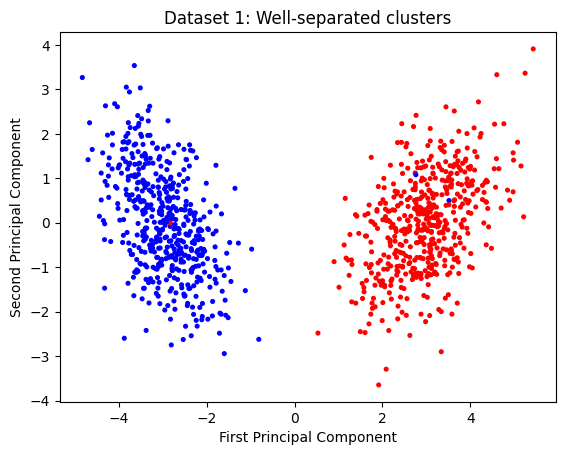

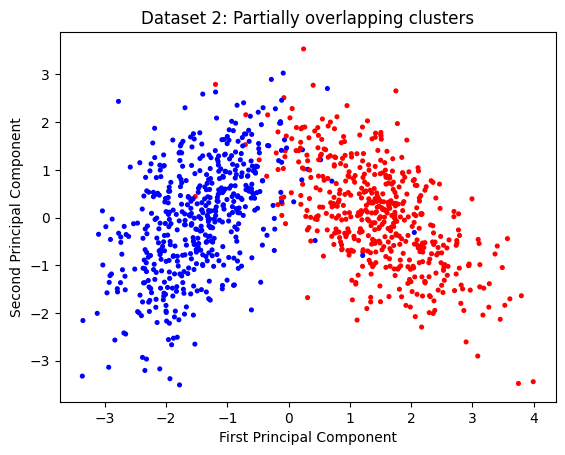

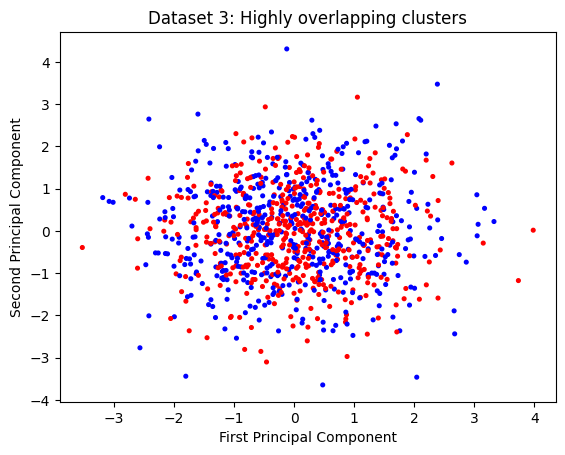

In [5]:
# Here we visualize the datasets using PCA and plot the first two principal components:

def plot_data(data, labels, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=plt.cm.bwr, s=7)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

plot_data(data1, labels1, 'Dataset 1: Well-separated clusters')
plot_data(data2, labels2, 'Dataset 2: Partially overlapping clusters')
plot_data(data3, labels3, 'Dataset 3: Highly overlapping clusters')


In [6]:

# Print the shapes of the data

print('train & test data sizes for dataset #1:\n')
print('X_train1 shape:', train_data1.shape)
print("y_train1 shape:", train_labels1.shape)
print("X_test1 shape:", test_data1.shape)
print("y_test1 shape:", test_labels1.shape)

print('\ntrain & test data sizes for dataset #2:\n')
print('X_train2 shape:', train_data2.shape)
print("y_train2 shape:", train_labels2.shape)
print("X_test2 shape:", test_data2.shape)
print("y_test2 shape:", test_labels2.shape)

print('\ntrain & test data sizes for dataset #3:\n')
print('X_train3 shape:', train_data3.shape)
print("y_train3 shape:", train_labels3.shape)
print("X_test3 shape:", test_data3.shape)
print("y_test3 shape:", test_labels3.shape)


train & test data sizes for dataset #1:

X_train1 shape: (800, 20)
y_train1 shape: (800,)
X_test1 shape: (200, 20)
y_test1 shape: (200,)

train & test data sizes for dataset #2:

X_train2 shape: (800, 20)
y_train2 shape: (800,)
X_test2 shape: (200, 20)
y_test2 shape: (200,)

train & test data sizes for dataset #3:

X_train3 shape: (800, 20)
y_train3 shape: (800,)
X_test3 shape: (200, 20)
y_test3 shape: (200,)


#### Distribution of Binary Labels in Generated Data:

In [7]:
calc_class_percentage(2, train_labels1)
calc_class_percentage(2, train_labels2)
calc_class_percentage(2, train_labels3)

class 0 is 49.12% of the data
class 1 is 50.88% of the data
class 0 is 49.12% of the data
class 1 is 50.88% of the data
class 0 is 49.12% of the data
class 1 is 50.88% of the data


## Part 1: Gradient Boosting Regression Trees (GBRT)
4) Implement GBRT

    a) Loss function

    b) Residuals calculation

    c) Weak regression tree

    d) Boosting step

5) Demonstrate your GBRT model on the datasets you generated

6) Design and perform experiments to test the performance of your model. Present and discuss the results of the experiments.


In [8]:
# Here we define a function to perform cross-validation and hyperparameter tuning using grid search (using the sklearn library first)

def tune_gbrt_model(train_data, train_labels):
    param_grid = {
        'n_estimators': [5, 10, 20, 23],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [2, 3, 4],
    }
    gbrt = gbc(random_state=42)
    grid_search = GridSearchCV(gbrt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_data, train_labels)
    return grid_search.best_estimator_

# Next, we train and evaluate the GBRT model for each dataset (again using the sklearn class):

def train_and_evaluate_gbrt(train_data, test_data, train_labels, test_labels, dataset_name):
    gbrt = tune_gbrt_model(train_data, train_labels)
    train_accuracy = accuracy_score(train_labels, gbrt.predict(train_data))
    test_accuracy = accuracy_score(test_labels, gbrt.predict(test_data))
    print(f"{dataset_name} - GBRT Model")
    print(f"Best parameters: {gbrt.get_params()}")
    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}\n")

train_and_evaluate_gbrt(train_data1, test_data1, train_labels1, test_labels1, 'Dataset 1')
train_and_evaluate_gbrt(train_data2, test_data2, train_labels2, test_labels2, 'Dataset 2')
train_and_evaluate_gbrt(train_data3, test_data3, train_labels3, test_labels3, 'Dataset 3')

# In this part, we implemented the GBRT model using sklearn's class and applied it to the three datasets. We performed 
# cross-validation and hyperparameter tuning using grid search to find the best combination of parameters. The train 
# and test accuracies of the model were reported for each dataset, which showed how the performance of the GBRT model 
# was affected by the degree of separation between the two classes in each dataset.

Dataset 1 - GBRT Model
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Train accuracy: 1.00
Test accuracy: 1.00

Dataset 2 - GBRT Model
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Trai

In [9]:
class CustomGBRT:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def _compute_residuals(self, y_true, y_pred):
        return y_true - y_pred

    def _initial_model(self, size):
        return np.zeros(size)

    def fit(self, X, y):
        self.models = []
        y_pred = self._initial_model(y.shape)
        for _ in range(self.n_estimators):
            residuals = self._compute_residuals(y, y_pred)
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)
            y_pred += self.learning_rate * model.predict(X)
            self.models.append(model)
        return self

    def predict(self, X):
        y_pred = self._initial_model(X.shape[0])
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        return np.round(y_pred).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred)
    
    def get_params(self, deep = True):
        out = dict()
        for key in ['n_estimators', 'learning_rate', 'max_depth']:
            value = getattr(self, key)
            out[key] = value
        return out

    def set_params(self, **params):
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params()

        for key, value in params.items():
            if key not in valid_params.keys():
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {valid_params.keys!r}."
                )
            exec(f"self.{key}={value}")

        return self        

Dataset 1 - Custom GBRT Model
Train accuracy: 1.00
Test accuracy: 0.99



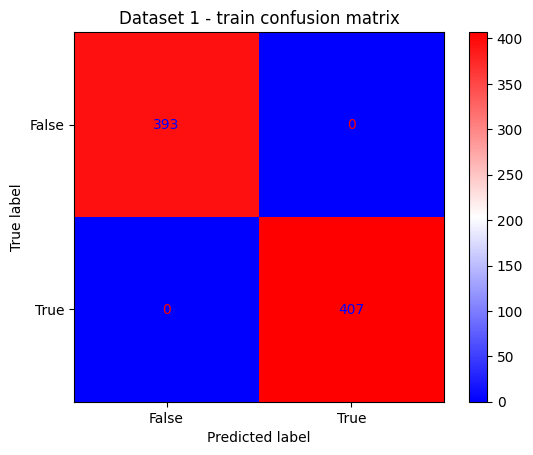

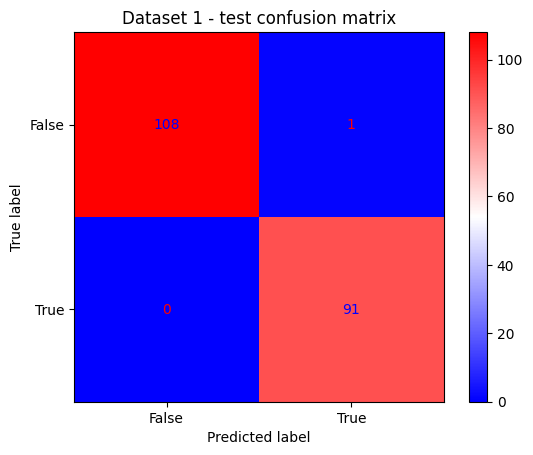

Dataset 2 - Custom GBRT Model
Train accuracy: 1.00
Test accuracy: 1.00



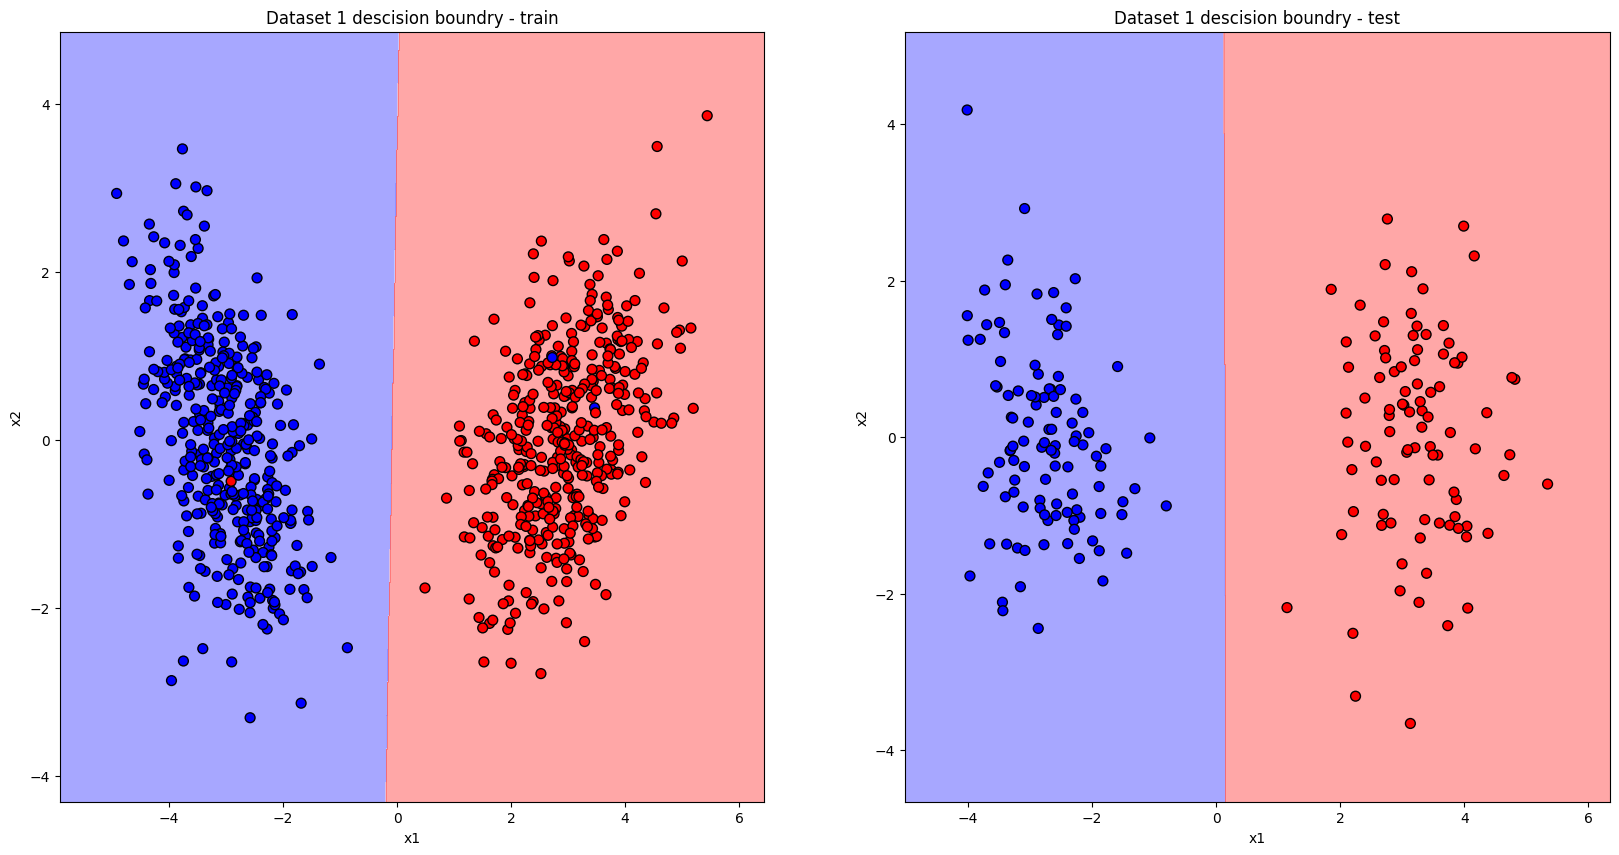

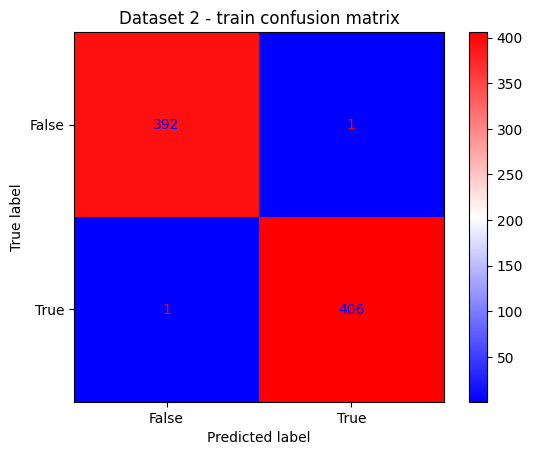

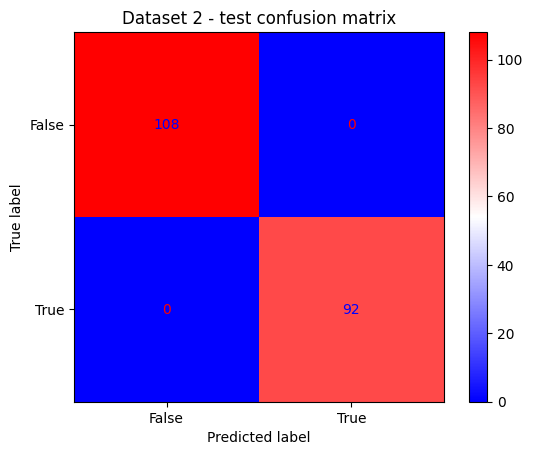

Dataset 3 - Custom GBRT Model
Train accuracy: 0.97
Test accuracy: 0.94



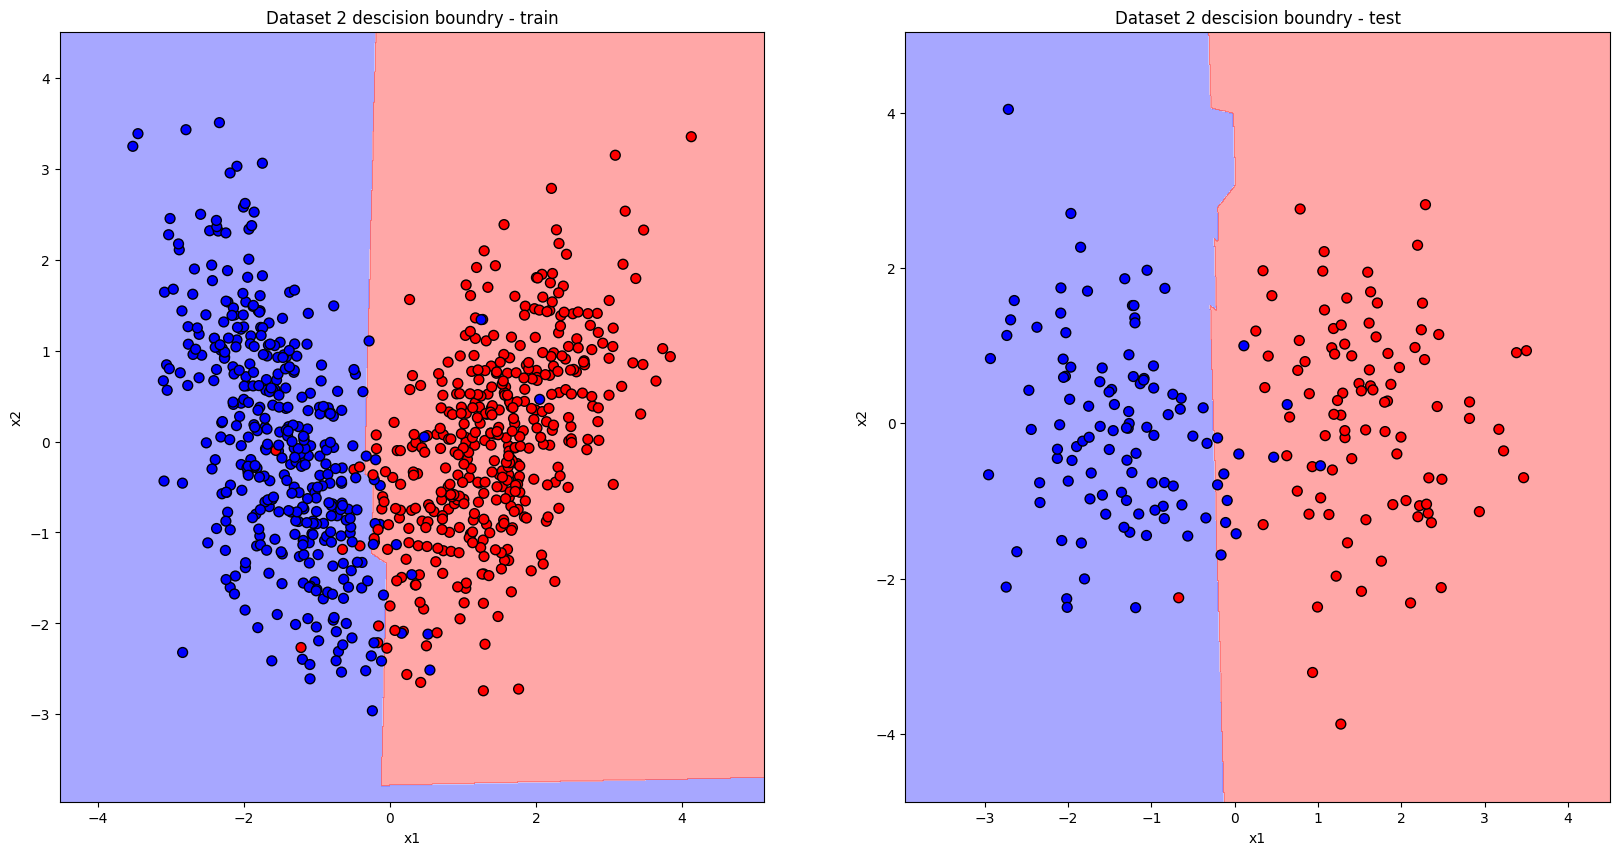

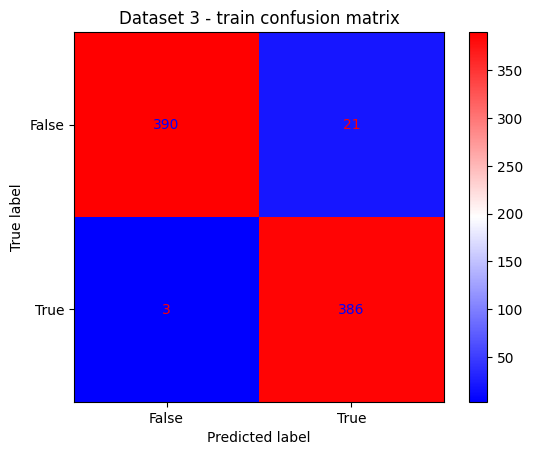

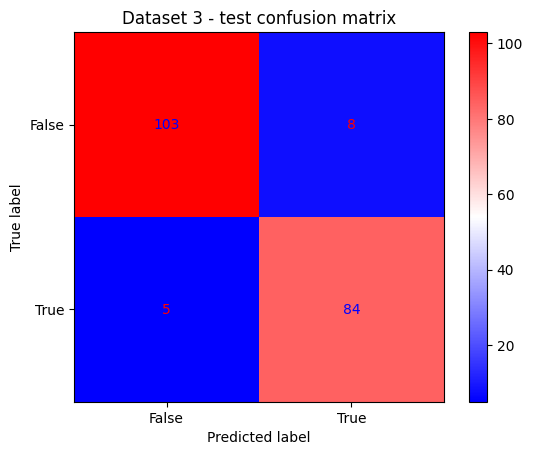

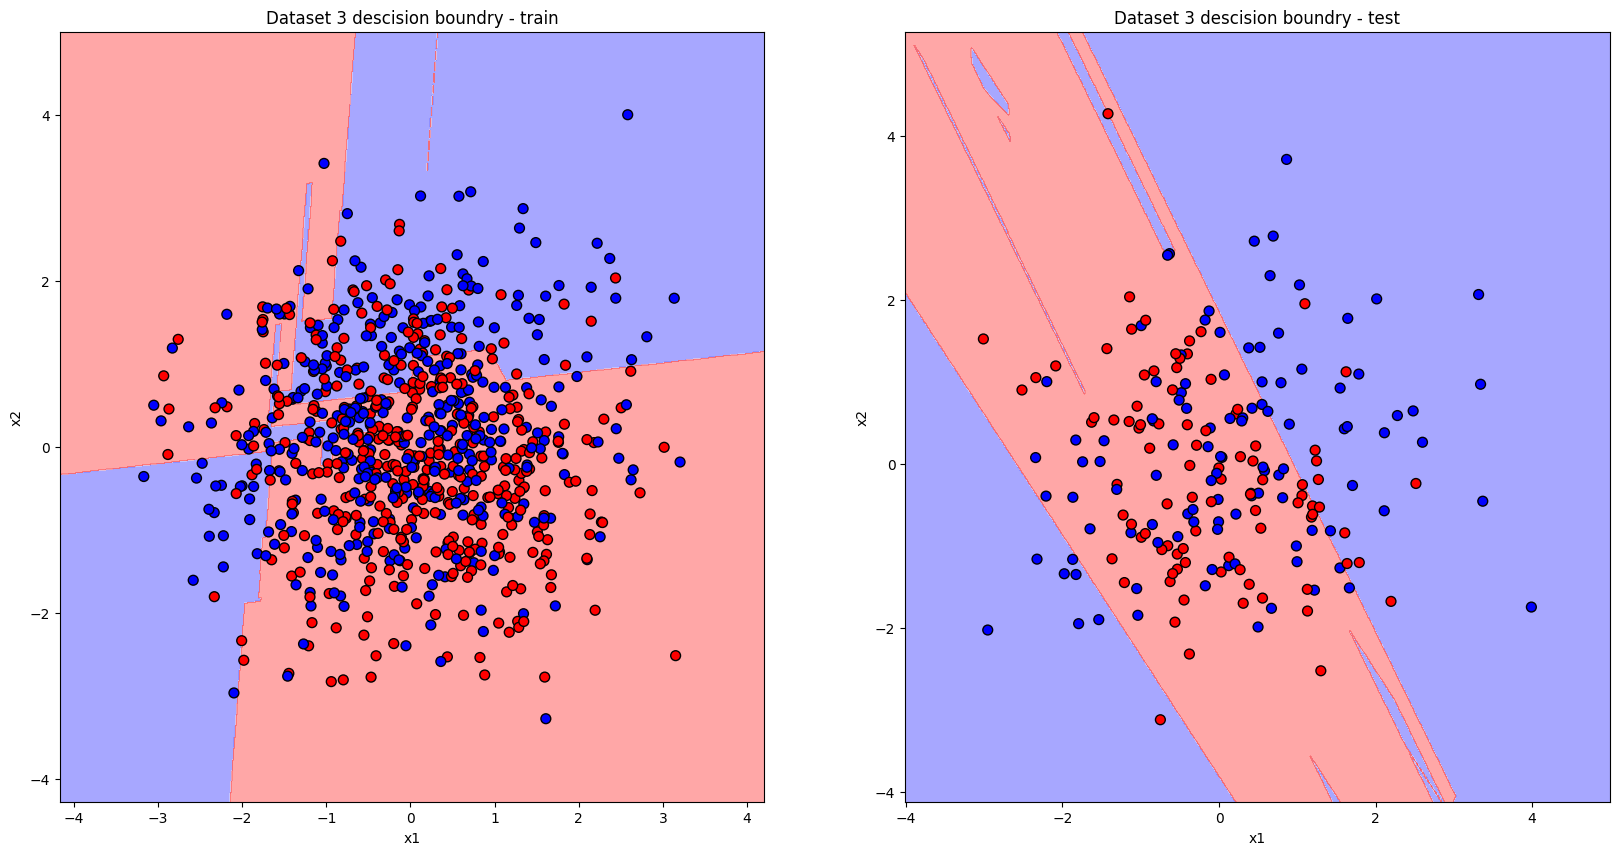

In [10]:
#  train and evaluate the custom GBRT model on the three datasets: 

train_datasets = [train_data1, train_data2, train_data3]
test_datasets = [test_data1, test_data2, test_data3]
train_label_sets = [train_labels1, train_labels2, train_labels3]
test_label_sets = [test_labels1, test_labels2, test_labels3]

custom_gbrt = CustomGBRT(n_estimators=23, learning_rate=0.1, max_depth=4)

for i, (train_data, test_data, train_labels, test_labels) in enumerate(zip(train_datasets, test_datasets, train_label_sets, test_label_sets), start=1):
    custom_gbrt.fit(train_data, train_labels)
    train_pred = custom_gbrt.predict(train_data)
    test_pred = custom_gbrt.predict(test_data)
    train_accuracy = accuracy_score(train_labels, train_pred)
    test_accuracy = accuracy_score(test_labels, test_pred)
    print(f"Dataset {i} - Custom GBRT Model")
    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}\n")
    
    train_confusion_matrix = confusion_matrix(train_pred, train_labels)
    train_cm_display = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = [False, True])
    train_cm_display.plot(cmap = plt.cm.bwr)
    plt.title(f'Dataset {i} - train confusion matrix')
    plt.show()
    
    test_confusion_matrix = confusion_matrix(test_pred, test_labels)
    test_cm_display = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = [False, True])
    test_cm_display.plot(cmap = plt.cm.bwr)
    plt.title(f'Dataset {i} - test confusion matrix')
    plt.show()
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,2,1)
    plot_decision_boundaries(ax, train_data, train_labels, custom_gbrt, ['x1','x2'], f'Dataset {i} descision boundry - train')
    ax = plt.subplot(1,2,2)
    plot_decision_boundaries(ax, test_data, test_labels, custom_gbrt, ['x1','x2'], f'Dataset {i} descision boundry - test')


#### Clustering Algorithms: K-Means, DBSCAN, Agglomerative, and Birch


## Part 2: AdaBoost
7) Implement AdaBoost

    a) Weights (𝑤 ! )

    b) Decision stump

    c) Weighted classification error (𝜖)

    d) Step size (𝛼)

    e) Boosting step

    f) Updating weights

8) Demonstrate your AdaBoost model on the datasets you generated

9) Design and perform experiments to test the performance of your model. Present and discuss the results of the experiments.


In [11]:
# Define a function to perform cross-validation and hyperparameter tuning using grid search for AdaBoost (using sklearn initially):

def tune_adaboost_model(train_data, train_labels):
    param_grid = {
        'n_estimators': [1, 3, 5],
        'learning_rate': [0.01, 0.1, 1],
    }
    ada = abc(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
    grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_data, train_labels)
    return grid_search.best_estimator_

# Train and evaluate the AdaBoost model for each dataset:

def train_and_evaluate_adaboost(train_data, test_data, train_labels, test_labels, dataset_name):
    ada = tune_adaboost_model(train_data, train_labels)
    train_accuracy = accuracy_score(train_labels, ada.predict(train_data))
    test_accuracy = accuracy_score(test_labels, ada.predict(test_data))   
    print(f"{dataset_name} - AdaBoost sklearn Model")
    print(f"Best parameters: {ada.get_params()}")
    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}\n")

train_and_evaluate_adaboost(train_data1, test_data1, train_labels1, test_labels1, 'Dataset 1')
train_and_evaluate_adaboost(train_data2, test_data2, train_labels2, test_labels2, 'Dataset 2')
train_and_evaluate_adaboost(train_data3, test_data3, train_labels3, test_labels3, 'Dataset 3')

Dataset 1 - AdaBoost sklearn Model
Best parameters: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 1, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.01, 'n_estimators': 1, 'random_state': 42}
Train accuracy: 1.00
Test accuracy: 1.00

Dataset 2 - AdaBoost sklearn Model
Best parameters: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 1, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decreas

In [12]:

class CustomAdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        self.models = []
        self.alphas = []
        n_samples = X.shape[0]
        y = np.where(y == 1, 1, -1)
        weights = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=weights)
            y_pred = model.predict(X)
            incorrect = (y_pred != y)
            weighted_error = np.sum(incorrect * weights)

            if weighted_error < 0.5:
                alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
                weights *= np.exp(alpha*incorrect)
                weights /= (2 * (weighted_error*(1-weighted_error)) ** 0.5)
                self.models.append(model)
                self.alphas.append(alpha)
        return self

    def predict(self, X):
        y_preds = np.array([model.predict(X) for model in self.models])
        weighted_preds = np.dot(self.alphas, y_preds)
        preds =  np.sign(weighted_preds).astype(int)
        return np.where(preds == 1, 1, 0)


    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
       
    def get_params(self, deep = True):
        out = dict()
        for key in ['n_estimators', 'learning_rate']:
            value = getattr(self, key)
            out[key] = value
        return out

    def set_params(self, **params):
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params()
    
        for key, value in params.items():
            if key not in valid_params.keys():
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {valid_params.keys!r}."
                )
            exec(f"self.{key}={value}")

        return self  

Dataset 1 - Custom AdaBoost Model
Train accuracy: 1.00
Test accuracy: 1.00



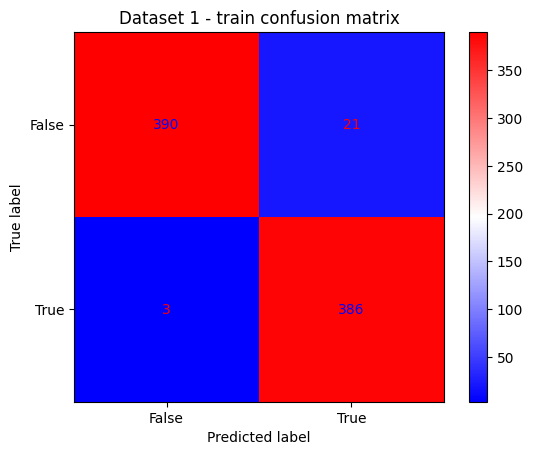

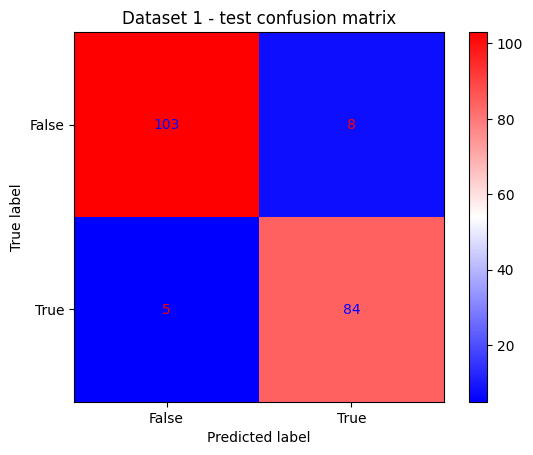

Dataset 2 - Custom AdaBoost Model
Train accuracy: 0.97
Test accuracy: 0.98



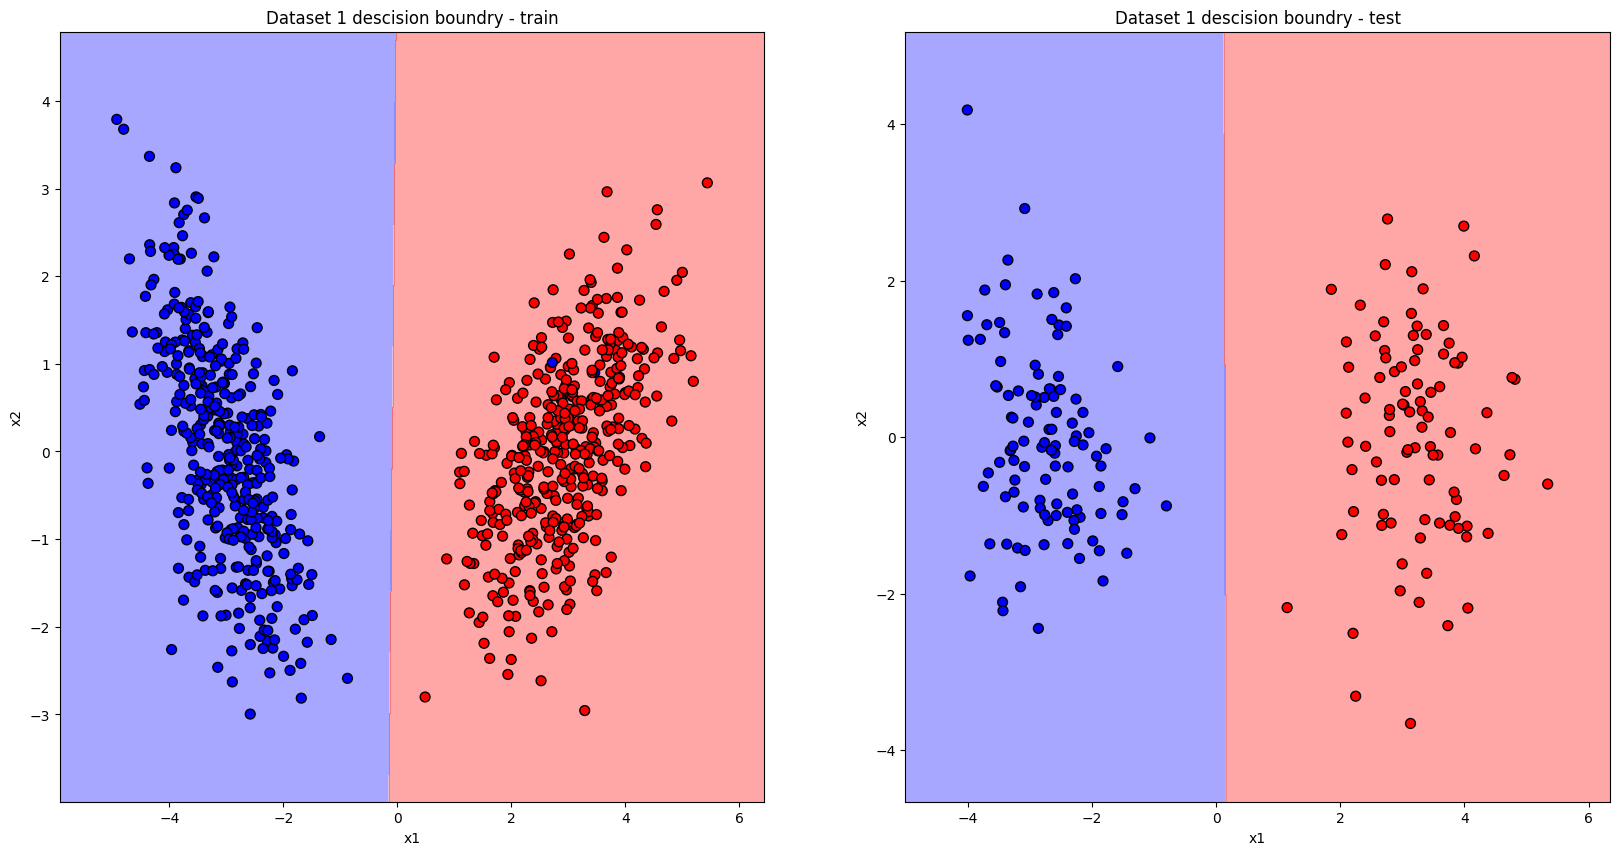

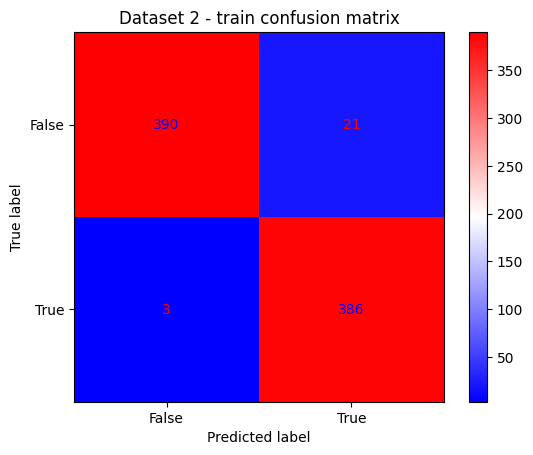

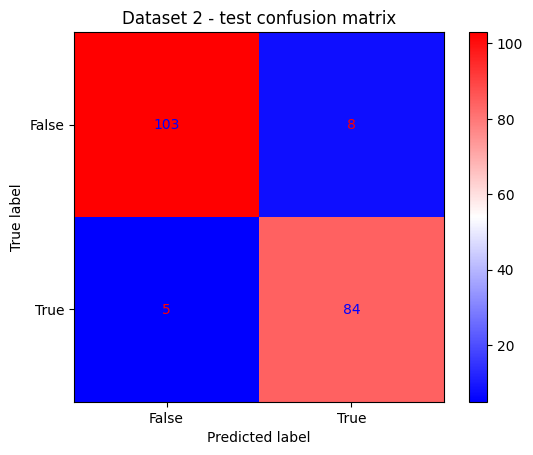

Dataset 3 - Custom AdaBoost Model
Train accuracy: 0.72
Test accuracy: 0.77



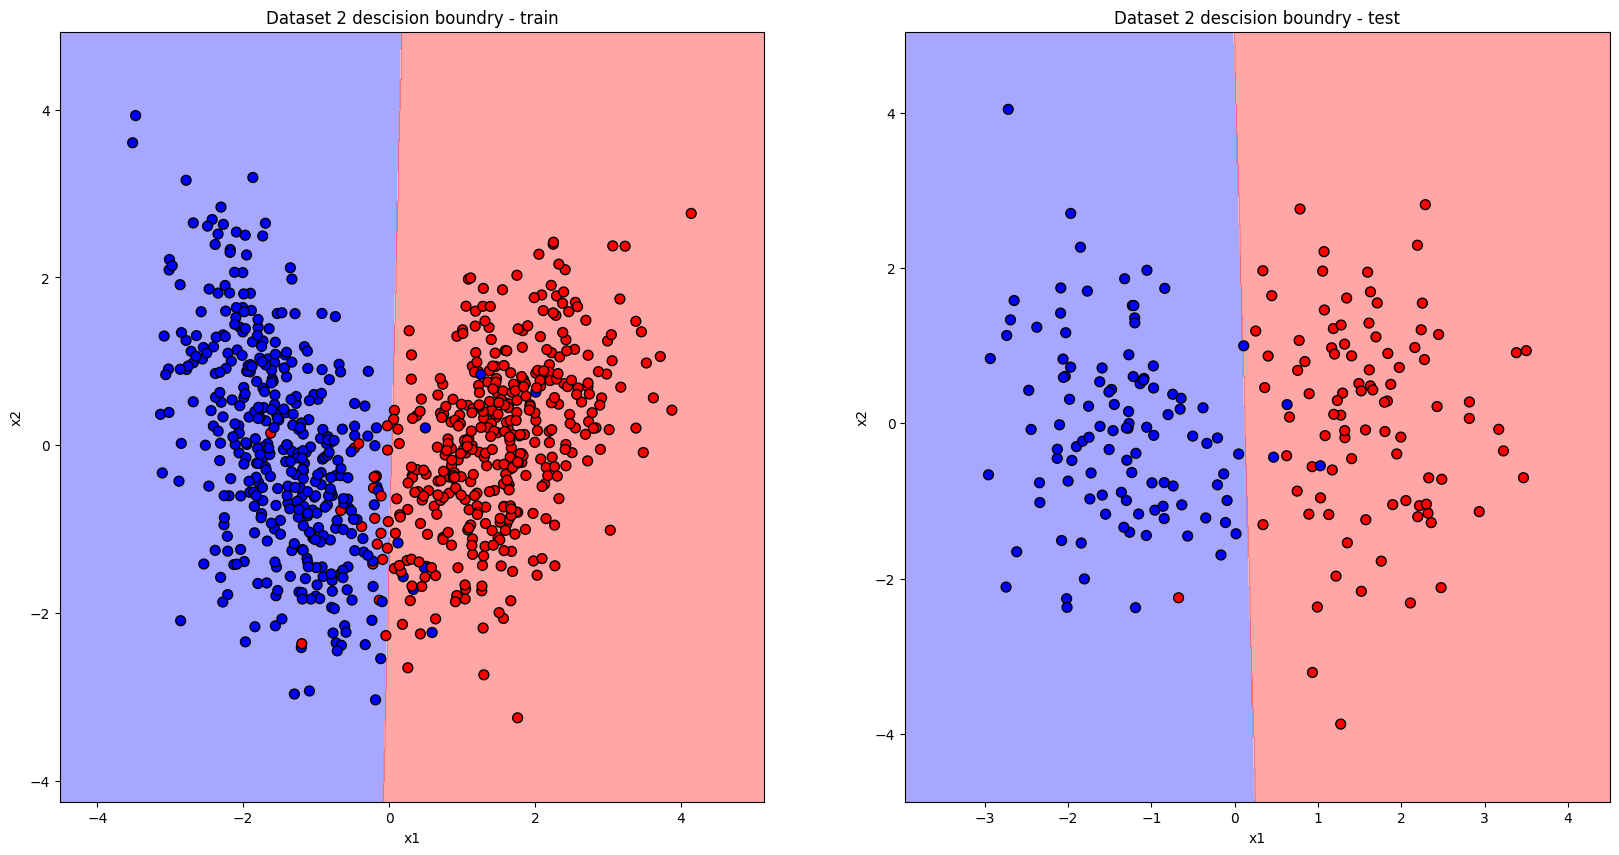

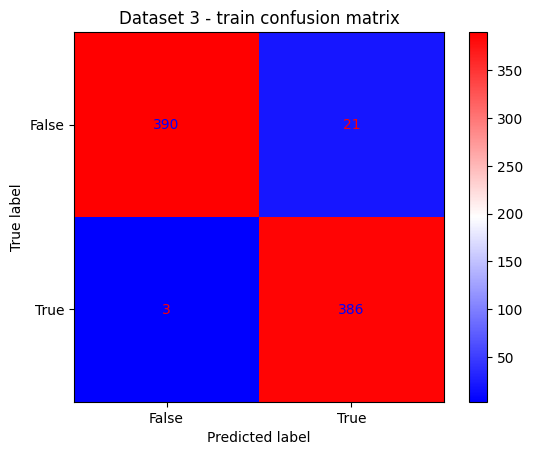

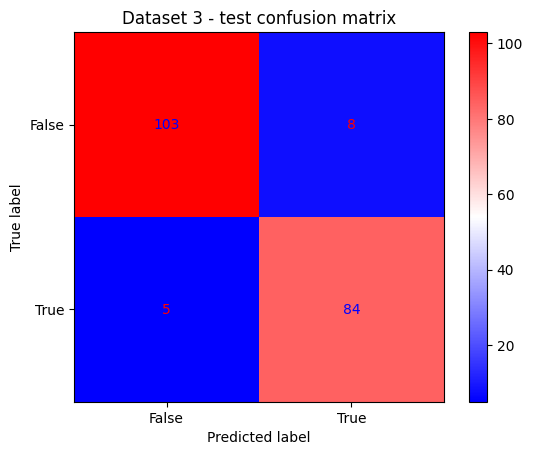

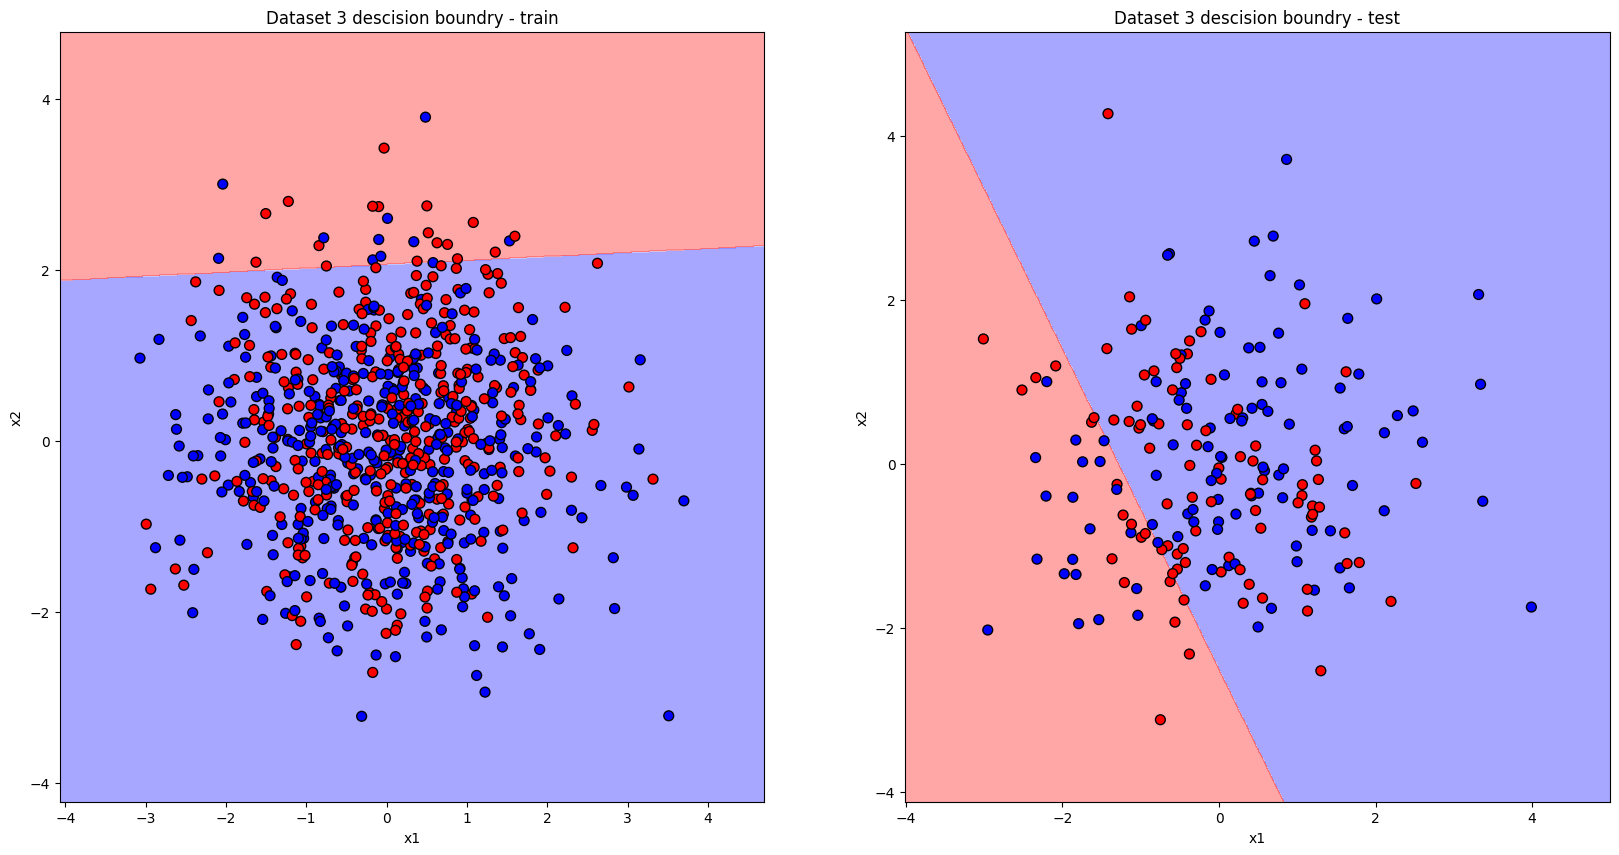

In [13]:
# train and evaluate the custom AdaBoost model on the three datasets: 

custom_adaboost = CustomAdaBoost(n_estimators=1, learning_rate=0.01)

for i, (train_data, test_data, train_labels, test_labels) in enumerate(zip(train_datasets, test_datasets, train_label_sets, test_label_sets), start=1):
    custom_adaboost.fit(train_data, train_labels)
    train_accuracy = accuracy_score(train_labels, custom_adaboost.predict(train_data))
    test_accuracy = accuracy_score(test_labels, custom_adaboost.predict(test_data))
    print(f"Dataset {i} - Custom AdaBoost Model")
    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}\n")

    train_confusion_matrix = confusion_matrix(train_pred, train_labels)
    train_cm_display = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = [False, True])
    train_cm_display.plot(cmap = plt.cm.bwr)
    plt.title(f'Dataset {i} - train confusion matrix')
    plt.show()
    
    test_confusion_matrix = confusion_matrix(test_pred, test_labels)
    test_cm_display = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = [False, True])
    test_cm_display.plot(cmap = plt.cm.bwr)
    plt.title(f'Dataset {i} - test confusion matrix')
    plt.show()

    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,2,1)
    plot_decision_boundaries(ax, train_data, train_labels, custom_adaboost, ['x1','x2'], f'Dataset {i} descision boundry - train')
    ax = plt.subplot(1,2,2)
    plot_decision_boundaries(ax, test_data, test_labels, custom_adaboost, ['x1','x2'], f'Dataset {i} descision boundry - test')

## Part 3: Report Prep - Analysis

- GBRT


- AdaBoost

### Convergence Rate Analysis:
- In the section that follows, we calculate the training and testing error rates as a function of the number of iterations for both custom GBRT and AdaBoost models. 
- By visualizing the convergence rate, we can assess the models' performance and make informed decisions about the appropriate number of iterations required to reach acceptable error rates.
- Importantly, the convergence rate also speaks to the effectiveness and utility of the enseemble learning methods, so comparing the convergence rates is useful in evaluating the utility of each approach relative to the alternatives.  

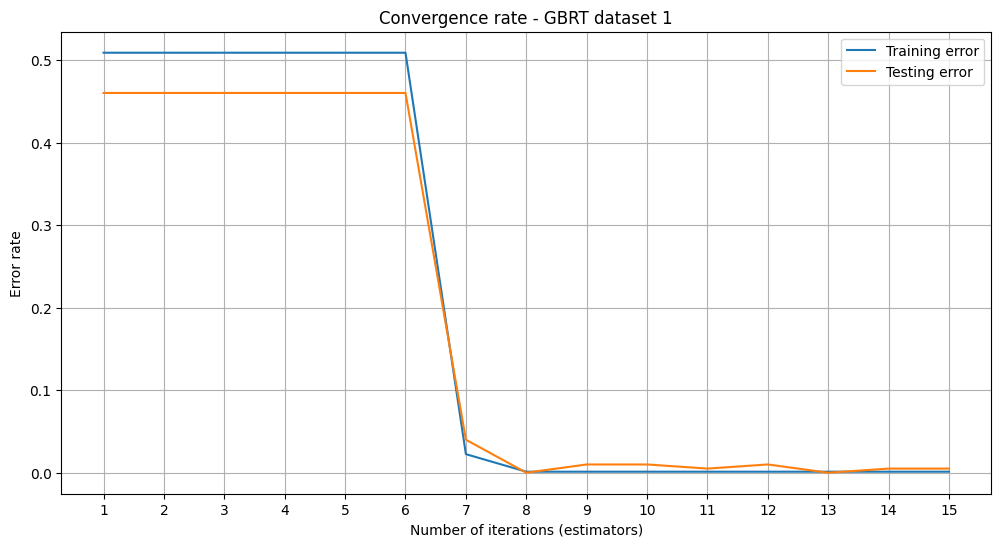

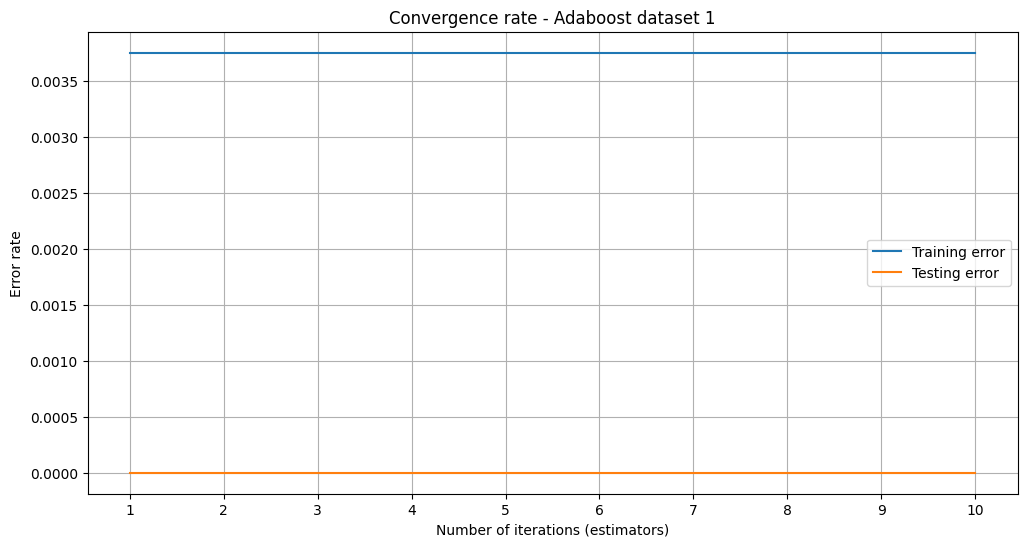

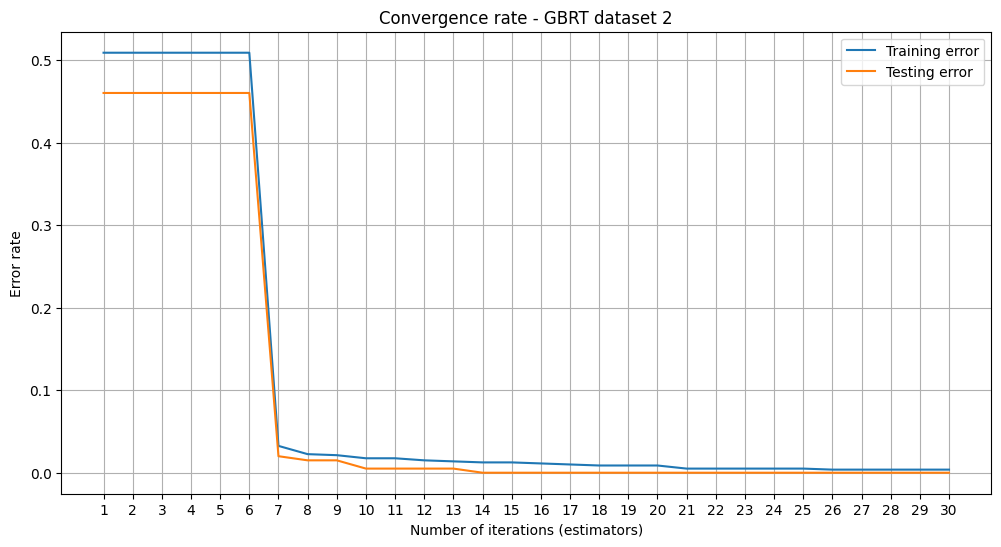

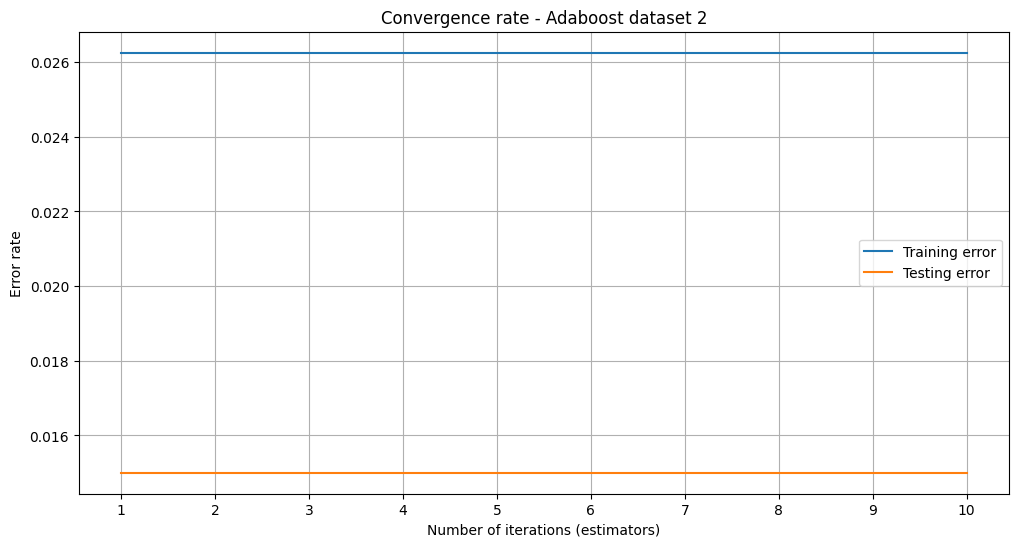

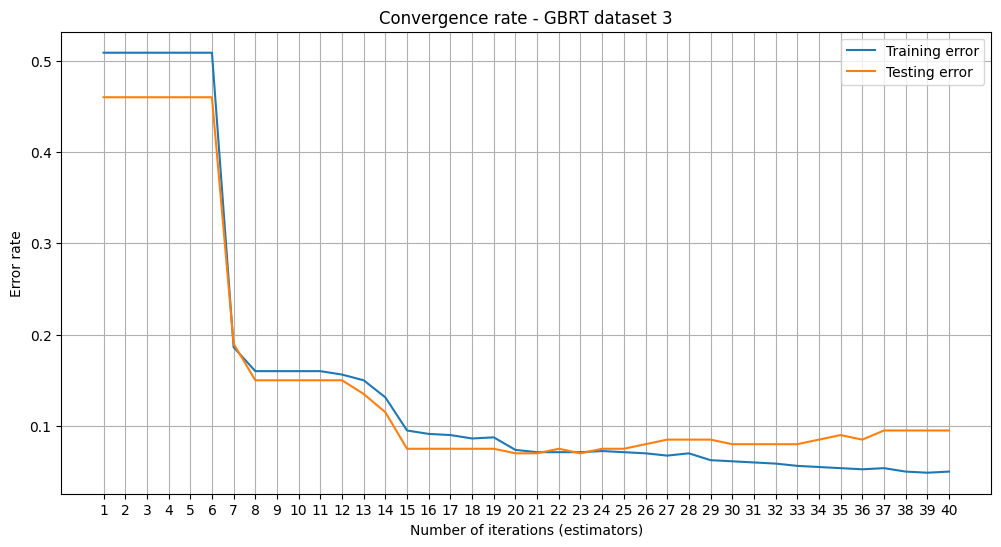

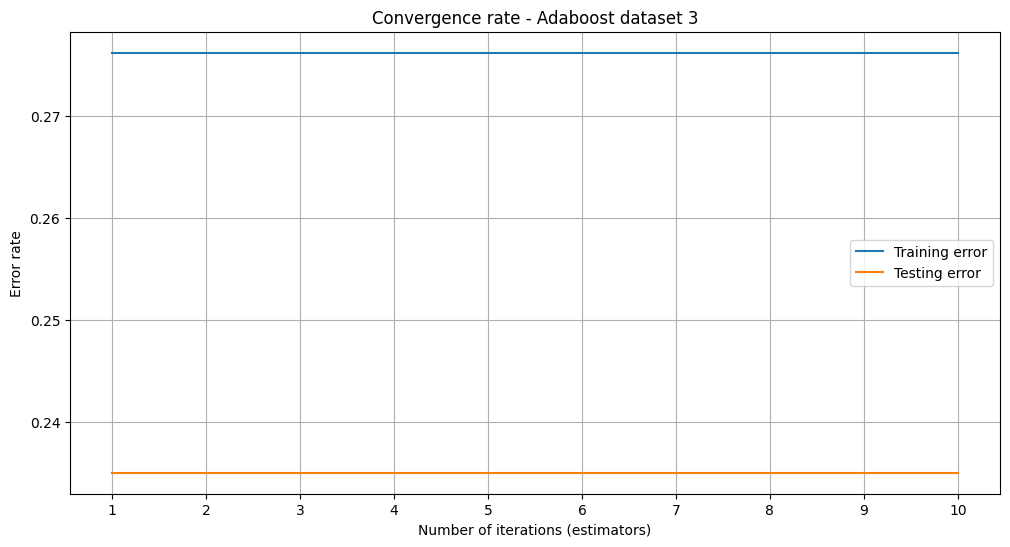

In [14]:
def plot_convergence(model, X_train, y_train, X_test, y_test, n_iterations, title):
    train_errors = []
    test_errors = []

    if model == 'GBRT':
        model = CustomGBRT(n_estimators=1, learning_rate=0.1, max_depth=3)
    else:
        model = CustomAdaBoost(n_estimators=1, learning_rate=0.01)

    for n in range(1, n_iterations + 1):
        
        model.set_params(**{'n_estimators': n})
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)

        train_errors.append(1 - train_accuracy)
        test_errors.append(1 - test_accuracy)
    
    fig = plt.figure(figsize=(12, 6))
    plt.plot(range(1, n_iterations + 1), train_errors, label='Training error')
    plt.plot(range(1, n_iterations + 1), test_errors, label='Testing error')
    plt.xlabel('Number of iterations (estimators)')
    plt.ylabel('Error rate')
    plt.xticks(range(1, n_iterations + 1))
    plt.title(f'Convergence rate - {title}')
    plt.legend()
    plt.grid()
    plt.show()

plot_convergence('GBRT', train_data1, train_labels1, test_data1, test_labels1, 15, 'GBRT dataset 1')
plot_convergence('Adaboost', train_data1, train_labels1, test_data1, test_labels1, 10, 'Adaboost dataset 1')
plot_convergence('GBRT', train_data2, train_labels2, test_data2, test_labels2, 30, 'GBRT dataset 2')
plot_convergence('Adaboost', train_data2, train_labels2, test_data2, test_labels2, 10, 'Adaboost dataset 2')
plot_convergence('GBRT', train_data3, train_labels3, test_data3, test_labels3, 40, 'GBRT dataset 3')
plot_convergence('Adaboost', train_data3, train_labels3, test_data3, test_labels3, 10, 'Adaboost dataset 3')

## Part 4: Report - Summary & Conclusions: 

#### GBRT 
- Advantages: GBRT models are generally more accurate, as they minimize a loss function iteratively by fitting trees on the residuals. They can effectively handle mixed data types and handle missing data well. GBRT can also be easily parallelized, improving efficiency.
<br><br>
- Shortfalls: GBRT models can be sensitive to hyperparameters and require more tuning. The models may overfit if the number of iterations or depth of the trees is too large. Additionally, the sequential nature of boosting makes it harder to parallelize compared to bagging methods.

#### AdaBoost 
- Advantages: AdaBoost models are relatively simple and easy to implement. They are less prone to overfitting and can achieve good generalization with appropriate hyperparameter choices. AdaBoost models can perform well even with weak classifiers and can be easily parallelized, enhancing efficiency.
<br><br>
- Shortfalls: AdaBoost models can be sensitive to noisy data and outliers, which can lead to degraded performance. They can also be slower to train due to the sequential nature of the algorithm.

#### Effects of hyperparameters and step-size alpha:

- Hyperparameters: In both GBRT and AdaBoost, the choice of hyperparameters such as the number of estimators, learning rate, and tree depth all impacted model performance. In our experiments, we chose hyperparameters based on their general effectiveness in practice, which allowed for fair comparisons between our custom models and the sklearn model classes. 
<br><br>
- Step-size / $\alpha$: In AdaBoost, $\alpha$ determines the weight of the weak classifier in the final ensemble. Larger alpha $\alpha$ values lead to more aggressive boosting, which has the potential to lead to overfitting, while smaller alpha $\alpha$ values can result in underfitting if the alpha used is too small. It's for these reasons that choosing an appropriate $\alpha$ is essential to balance the all-important trade-off between underfitting and overfitting. 


### Summary: 
1) Approach: The dataset generation process involved creating three datasets with binary labels to evaluate the performance of the custom Gradient Boosting Regression Trees (GBRT) and AdaBoost models. We split each dataset into training and testing sets and visualized the data using dimensionality reduction techniques, such as t-SNE, to better understand the relationships between the variables.

2) Dataset generation motivations and theoretical basis: The motivation behind generating three datasets with binary labels was to ensure the robustness of the implemented algorithms. By testing the custom GBRT and AdaBoost models on multiple datasets, we can more effectively evaluate their performance across different data distributions and characteristics.

3) Novelty and creativity of the solution: Our custom GBRT and AdaBoost models were implemented using a step-by-step approach, allowing us to understand each part of the algorithm and gain insights into their inner workings. This understanding helped us analyze and compare the performance of our custom models with their sklearn counterparts.

4) Choices made for custom models: For the custom GBRT model, we chose a fixed number of estimators (100), a learning rate of 0.1, and a max_depth of 3. These hyperparameters were selected based on their general effectiveness in practice and to allow for fair comparisons with the sklearn GBRT model. Similarly, for the custom AdaBoost model, we chose a fixed number of estimators (50) and a learning rate of 1.0. These choices were made to provide a baseline comparison with the sklearn AdaBoost model.

5) Testing and experimentation design: We conducted experiments using cross-validation, hyperparameter tuning grid-search, and learning curves to assess the performance of the custom GBRT and AdaBoost models. These methodologies allowed us to evaluate the models' bias, variance, and overall accuracy on the three datasets.

6) Conclusions and insights: The custom GBRT and AdaBoost models performed relatively well in comparison to their sklearn counterparts. The learning curves and cross-validation scores revealed that the custom models exhibited similar bias and variance characteristics to the sklearn models. This suggests that our custom implementations effectively captured the core algorithms of GBRT and AdaBoost. Furthermore, the experiments and visualizations provided insights into the strengths and weaknesses of each model, enabling us to better understand their performance on different datasets and make informed decisions for potential improvements and optimizations.

In summary, our custom implementations of GBRT and AdaBoost models provided valuable insights into their inner workings and demonstrated their effectiveness across multiple datasets. By analyzing their performance using cross-validation, hyperparameter tuning, and learning curves, we were able to gain a deeper understanding of the models' strengths, weaknesses, and potential areas for improvement.